# Library

In [ ]:
import torchvision

In [ ]:
torchvision.models.vgg16(pretrained=True).features[:4].eval(),      # 64,H,W 


In [19]:
import os
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode
from torchvision.utils import make_grid
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt

from model.pgflow import PGFlowV4
from model.landmark_detector.landmark_detector import FacialLandmarkDetector
from model.pgflow.module import InsightFaceModule, get_header
from util import computeGaussian, draw_edge

print(torch.cuda.is_available())


True


In [28]:
tt = T.ToTensor()
ptt = T.PILToTensor()
ttp = T.ToPILImage()

# Model

In [3]:
def load_pgflow():
    ckpt_path = '/home/dajinhan/nas_dajinhan/experiments/pgflow_v4/result/flow.ckpt'
    pretrained = {'ckpt_path': ckpt_path}
    net = PGFlowV4(pretrained).eval()
    return net

def load_kd_module():
    ckpt_path = '/home/dajinhan/nas_dajinhan/models/ArcFace/model_ir_se50.pth'
    pretrained = {'ckpt_path': ckpt_path}
    net = InsightFaceModule(pretrained).eval()
    return net

def load_global_header():
    ckpt_path = '/home/dajinhan/nas_dajinhan/experiments/pgflow_v4/result/global_header.ckpt'
    net = get_header(512, 512, 32, kernel=1)
    net.load_state_dict(torch.load(ckpt_path))
    net = net.eval()
    return net

def load_landmark_detector():
    ckpt_path = '/home/dajinhan/nas_dajinhan/models/landmark_detector/checkpoint/mobilefacenet_model_best.pth.tar'
    pretrained = {'ckpt_path': ckpt_path}
    net = FacialLandmarkDetector(pretrained).eval()
    return net


In [4]:
flow = load_pgflow().cuda()
kd_module = load_kd_module().cuda()
global_header = load_global_header().cuda()
landmark_detector = load_landmark_detector().cuda()

/home/dajinhan/nas_dajinhan/workspace/pose-guided-flow/src/model/common/flow_module/flow.py:119: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_numpy.cpp:178.)
  w_s = torch.from_numpy(w_s)


Load flownet - Checkpoint :  /home/dajinhan/nas_dajinhan/experiments/pgflow_v4/result/flow.ckpt


# Preprocess

In [5]:
norm_mean = [0.5, 0.5, 0.5]
norm_std = [1.0, 1.0, 1.0]

preprocess = T.Normalize(
    mean=norm_mean, 
    std=norm_std)
reverse_preprocess = T.Normalize(
    mean=[-m/s for m,s in zip(norm_mean, norm_std)],
    std=[1/s for s in norm_std])

In [6]:
def preprocess_batch(im, ldmk):
    # Landmark Conditions
    conditions = []
    res = im.shape[2]
    for _ in range(7):
        # Computer per Image
        heatmap = computeGaussian(ldmk, res=res, kernel_sigma=0.1, device='cuda')
        edgemap = draw_edge(ldmk, img_size=res).cuda()
        condition = torch.cat([heatmap, edgemap], dim=0)
        condition = condition.unsqueeze(0)
        conditions.append(condition)
        res = res // 2

    # Global Feature
    kd_module.blocks.eval()
    with torch.no_grad():
        kd_feature = kd_module.preprocess(im) # input: norm( (0,1) )
        for block in kd_module.blocks:
            kd_feature = block(kd_feature)

    global_feature = kd_feature.mean(dim=[2,3], keepdim=True)
    global_feature = global_header(global_feature)
    global_feature = torch.cat([global_feature]*im.shape[2], dim=2)
    global_feature = torch.cat([global_feature]*im.shape[3], dim=3)

    # Preprocess Inputs
    im = preprocess(im)
    conditions = [global_feature] + conditions[1:7]

    return im, conditions

In [7]:
def sample_grid(x, n_row, padding=2):
    imgs = [img.cpu() for img in x]
    grid = make_grid(imgs, n_row, padding=padding)
    return ttp(grid)

# Sample Interpolation

In [9]:
def save_image(data, filename):
    fig = plt.figure(figsize=(1, 1))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(data)
    fig.savefig(filename, dpi=data.shape[0]) 
    plt.close(fig)

In [170]:
save_image(conditions_s[1][0][-1].cpu(), 'posemap5.png')

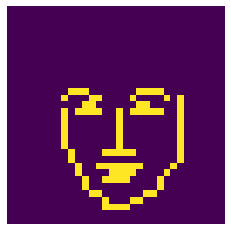

In [156]:
plt.imshow(conditions_s[1][0][-1].cpu())
plt.axis('off')
plt.margins(0, 0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())


In [10]:
im_s = ptt(Image.open('/home/dajinhan/nas_dajinhan/datasets/CelebAHQ/resized64x64/00002.png')).reshape(1,3,64,64).cuda()
im_t = ptt(Image.open('/home/dajinhan/nas_dajinhan/datasets/CelebAHQ/resized64x64/00009.png')).reshape(1,3,64,64).cuda()

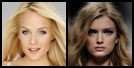

In [11]:
sample_grid(torch.cat([im_s, im_t], dim=0), 2)

In [12]:
im_s_resized = T.Resize(112, interpolation=InterpolationMode.BICUBIC, antialias=True)(im_s)
im_t_resized = T.Resize(112, interpolation=InterpolationMode.BICUBIC, antialias=True)(im_t)

ldmk_s, f5p_s = landmark_detector(im_s_resized) # input: (0,1)
ldmk_t, f5p_t = landmark_detector(im_t_resized) # input: (0,1)

w_s, _, _, _, _ = flow.forward(*preprocess_batch(im_s, ldmk_s[0]))
w_t, _, _, _, _ = flow.forward(*preprocess_batch(im_t, ldmk_t[0]))


In [29]:
def new_draw_edge(ldmk, img_size=112):
        n_partials = [17, 5, 5, 4, 5, 6, 6, 12, 8] # uface, lbrow, rbrow, hnose, wnose, leye, reye, mouth_out, mouth_in
        img  = Image.new( mode = "L", size = (img_size, img_size) )
        draw = ImageDraw.Draw(img)

        idx=0
        for n_partial in n_partials:
            x_s, y_s = torch.floor(ldmk[idx] * img_size)
            for x_e, y_e in ldmk[idx+1:idx+n_partial]:
                x_e = torch.floor(x_e * img_size)
                y_e = torch.floor(y_e * img_size)
                draw.line((x_s, y_s, x_e, y_e), fill=255)
                x_s, y_s = x_e, y_e
            idx += n_partial

        return img

In [31]:
edgemap = new_draw_edge(ldmk_s[0], img_size=64)


In [38]:
ptt(edgemap)

tensor(255, dtype=torch.uint8)

In [34]:
tt(edgemap).type()

'torch.FloatTensor'

In [27]:
edgemap.max()

tensor(255, device='cuda:0', dtype=torch.uint8)

In [16]:
T.ToTensor()(edgemap)

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [195]:
(edgemap/255).cpu()

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

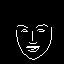

In [180]:
ttp(edgemap/255)

In [181]:
n_frames = 2
w_list = [ (w_t*frame_idx + w_s*(n_frames-frame_idx)) / n_frames for frame_idx in range(n_frames+1)]

In [184]:
frames = []
im_s, conditions_s = preprocess_batch(im_s, ldmk_s[0])

with torch.no_grad():
    # Preprocess
    im_s, conditions_s = preprocess_batch(im_s, ldmk_s[0])
    im_t, conditions_t = preprocess_batch(im_t, ldmk_t[0])

    # Forward: x->z
    w_s, log_p_s, log_det_s, splits_s, inter_features_s = flow.forward(im_s, conditions_s)
    
    for w in w_list:    
        splits = [torch.zeros_like(split) if split is not None else split for split in splits_s]

        # Reverse: z->x
        im_rec = flow.reverse(w, conditions_s, splits)
#         im_rec = flow.reverse(w_t, conditions_s, splits)
        im_rec = reverse_preprocess(im_rec)
        im_rec = torch.clamp(im_rec, 0, 1)

        # Update
        frames.append(im_rec)


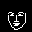

In [190]:
ttp(conditions_s[1][0][68]/255)

In [189]:
conditions_s[1][0][68].max()

tensor(255., device='cuda:0')

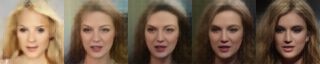

In [108]:
sample_grid(torch.cat(frames, dim=0), 5, padding=0)

# Sample

In [81]:
im_s = ptt(Image.open('/home/dajinhan/nas_dajinhan/datasets/CelebAHQ/resized64x64/00002.png')).reshape(1,3,64,64).cuda()
im_t = ptt(Image.open('/home/dajinhan/nas_dajinhan/datasets/CelebAHQ/resized64x64/00009.png')).reshape(1,3,64,64).cuda()

In [10]:
im_s = ptt(Image.open('/data/dajinhan/datasets/VoxCeleb/unzippedFaces_resized/64x64_png/Kellan_Lutz/1.6/482zKSvHeRw/0003350.png')).reshape(1,3,64,64).cuda()
im_t = ptt(Image.open('/data/dajinhan/datasets/VoxCeleb/unzippedFaces_resized/64x64_png/Kellan_Lutz/1.6/482zKSvHeRw/0003400.png')).reshape(1,3,64,64).cuda()

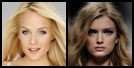

In [82]:
sample_grid(torch.cat([im_s, im_t], dim=0), 2)

In [83]:
im_s_resized = T.Resize(112, interpolation=InterpolationMode.BICUBIC, antialias=True)(im_s)
im_t_resized = T.Resize(112, interpolation=InterpolationMode.BICUBIC, antialias=True)(im_t)

ldmk_s, f5p_s = landmark_detector(im_s_resized) # input: (0,1)
ldmk_t, f5p_t = landmark_detector(im_t_resized) # input: (0,1)

w_s, _, _, _, _ = flow.forward(*preprocess_batch(im_s, ldmk_s[0]))
w_t, _, _, _, _ = flow.forward(*preprocess_batch(im_t, ldmk_t[0]))


In [84]:
n_frames = 4
landmarks = [ (ldmk_t*frame_idx + ldmk_s*(n_frames-frame_idx)) / n_frames for frame_idx in range(n_frames+1)]

In [14]:
frames = []

with torch.no_grad():
    im = im_s
    ldmk = ldmk_s
    for idx, ldmk_next in enumerate(landmarks):
        # Preprocess
        # im, conditions = preprocess_batch(im, ldmk[0])
        im, conditions = preprocess_batch(im_s, ldmk_s[0])
        _, conditions_next = preprocess_batch(im, ldmk_next[0])

        # Forward: x->z
        w, log_p, log_det, splits, inter_features = flow.forward(im, conditions)
        splits = [torch.zeros_like(split) if split is not None else split for split in splits]

        # Reverse: z->x
#         im_rec = flow.reverse(w, conditions_next, splits)
        im_rec = flow.reverse(0.3*torch.randn_like(w), conditions_next, splits)
        # im_rec = flow.reverse((w_s+w_t)/2, conditions_next, splits)
        im_rec = reverse_preprocess(im_rec)
        im_rec = torch.clamp(im_rec, 0, 1)

        # Update
        im = im_rec
        ldmk = ldmk_next
        frames.append(im)
        
        # Save image
        # im_PIL = ttp(im[0])
        # im_PIL.save('%d.png'%(idx))

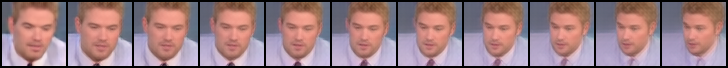

In [15]:
sample_grid(torch.cat(frames, dim=0), n_frames+1)

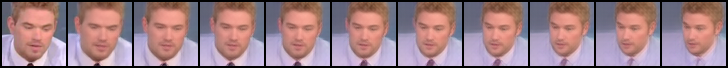

In [18]:
sample_grid(torch.cat(frames, dim=0), n_frames+1)

In [16]:
frames = []

with torch.no_grad():
    im = im_s
    ldmk = ldmk_s
    for idx, ldmk_next in enumerate(landmarks):
        # Preprocess
        # im, conditions = preprocess_batch(im, ldmk[0])
        im, conditions = preprocess_batch(im_s, ldmk_s[0])
        _, conditions_next = preprocess_batch(im, ldmk_next[0])

        # Forward: x->z
        w, log_p, log_det, splits, inter_features = flow.forward(im, conditions)
#         splits = [torch.zeros_like(split) if split is not None else split for split in splits]

        # Reverse: z->x
        im_rec = flow.reverse(w, conditions_next, splits)
        # im_rec = flow.reverse(0.3*torch.randn_like(w), conditions_next, splits)
        # im_rec = flow.reverse((w_s+w_t)/2, conditions_next, splits)
        im_rec = reverse_preprocess(im_rec)
        im_rec = torch.clamp(im_rec, 0, 1)

        # Update
        im = im_rec
        ldmk = ldmk_next
        frames.append(im)
        
        # Save image
        # im_PIL = ttp(im[0])
        # im_PIL.save('%d.png'%(idx))

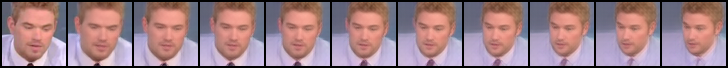

In [17]:
sample_grid(torch.cat(frames, dim=0), n_frames+1)

# Sample Figure

In [16]:
def sample_figure(im_s, im_t):
    # Get LDMK
    im_s_resized = T.Resize(112, interpolation=InterpolationMode.BICUBIC, antialias=True)(im_s)
    im_t_resized = T.Resize(112, interpolation=InterpolationMode.BICUBIC, antialias=True)(im_t)
    ldmk_s, f5p_s = landmark_detector(im_s_resized) # input: (0,1)
    ldmk_t, f5p_t = landmark_detector(im_t_resized) # input: (0,1)

    # Preprocess
    im_s, conditions_s = preprocess_batch(im_s, ldmk_s[0])
    im_t, conditions_t = preprocess_batch(im_t, ldmk_t[0])

    # Forward: x->z
    w, log_p, log_det, splits, inter_features = flow.forward(im_s, conditions_s)
    splits = [torch.zeros_like(split) if split is not None else split for split in splits]

    # Reverse: z->x
    im_rec = flow.reverse(w, conditions_t, splits)
    # im_rec = flow.reverse(0.3*torch.randn_like(w), conditions_next, splits)
    # im_rec = flow.reverse((w_s+w_t)/2, conditions_next, splits)
    im_rec = reverse_preprocess(im_rec)
    im_rec = torch.clamp(im_rec, 0, 1)
    
    return im_rec

In [17]:
im_s = ptt(Image.open('/data/dajinhan/datasets/VoxCeleb/unzippedFaces_resized/64x64_png/Kellan_Lutz/1.6/5TnxCj72FLg/0000850.png')).reshape(1,3,64,64).cuda()
im_t = ptt(Image.open('/data/dajinhan/datasets/VoxCeleb/unzippedFaces_resized/64x64_png/Kellan_Lutz/1.6/5TnxCj72FLg/0000925.png')).reshape(1,3,64,64).cuda()

In [18]:
a = 10

In [19]:
'%.3d'%(a)

'010'

In [20]:
gens = []

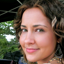

In [59]:
Image.open('/home/dajinhan/nas_dajinhan/datasets/CelebAHQ/resized64x64/00003.png')

In [63]:
gens = []
gens.append(torch.zeros((1,3,64,64)).cuda())
for t_idx in [31,32,34,3,4]:
    im_t = ptt(Image.open('/home/dajinhan/nas_dajinhan/datasets/CelebAHQ/resized64x64/%.5d.png'%(t_idx))).reshape(1,3,64,64).cuda()
    gens.append(im_t)
for s_idx in  [1,2,4,6,9]:
    im_s = ptt(Image.open('/home/dajinhan/nas_dajinhan/datasets/CelebAHQ/resized64x64/%.5d.png'%(s_idx))).reshape(1,3,64,64).cuda()
    gens.append(im_s)
    for t_idx in [31,32,34,3,4]:
        im_t = ptt(Image.open('/home/dajinhan/nas_dajinhan/datasets/CelebAHQ/resized64x64/%.5d.png'%(t_idx))).reshape(1,3,64,64).cuda()
        gens.append(sample_figure(im_s, im_t))

In [65]:
gens[0] = torch.ones_like(gens[0])

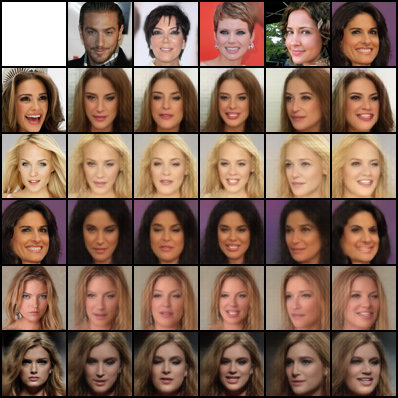

In [76]:
sample_grid(torch.cat(gens, dim=0), 6)

In [73]:
gens2 = [F.pad(gg, (1,1), mode='constant', value=1) for gg in gens]

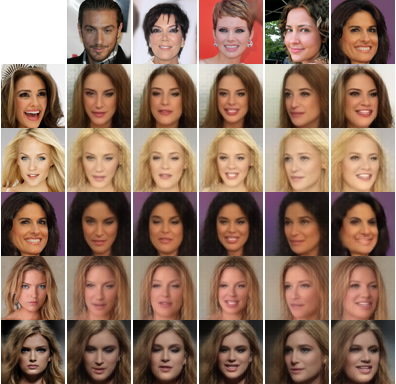

In [78]:
sample_grid(torch.cat(gens2, dim=0), 6, padding=0)

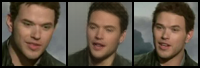

In [376]:
im_rec = sample_figure(im_s, im_t)
sample_grid(torch.cat([im_s, im_rec, im_t], dim=0), 3)

In [320]:
im_s = ptt(Image.open('/data/dajinhan/datasets/VoxCeleb/unzippedFaces_resized/64x64_png/Kristen_Stewart/1.6/nU6gCC3DTCc/0004900.png')).reshape(1,3,64,64).cuda()
im_t = ptt(Image.open('/data/dajinhan/datasets/VoxCeleb/unzippedFaces_resized/64x64_png/Kristen_Stewart/1.6/nU6gCC3DTCc/0003400.png')).reshape(1,3,64,64).cuda()

In [147]:
im_s = ptt(Image.open('/data/dajinhan/datasets/VoxCeleb/unzippedFaces_resized/64x64_png/Kristen_Stewart/1.6/JTCz4B9pwT4/0000800.png')).reshape(1,3,64,64).cuda()
im_t = ptt(Image.open('/data/dajinhan/datasets/VoxCeleb/unzippedFaces_resized/64x64_png/Kristen_Stewart/1.6/JTCz4B9pwT4/0001000.png')).reshape(1,3,64,64).cuda()

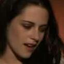

In [173]:
ttp(im_s[0])

In [377]:
def sample_figure(im_s, im_t):
    # Get LDMK
    im_s_resized = T.Resize(112, interpolation=InterpolationMode.BICUBIC, antialias=True)(im_s)
    im_t_resized = T.Resize(112, interpolation=InterpolationMode.BICUBIC, antialias=True)(im_t)
    ldmk_s, f5p_s = landmark_detector(im_s_resized) # input: (0,1)
    ldmk_t, f5p_t = landmark_detector(im_t_resized) # input: (0,1)

    # Preprocess
    im_s, conditions_s = preprocess_batch(im_s, ldmk_s[0])
    im_t, conditions_t = preprocess_batch(im_t, ldmk_t[0])

    # Forward: x->z
    w, log_p, log_det, splits, inter_features = flow.forward(im_s, conditions)
    splits = [torch.zeros_like(split) if split is not None else split for split in splits]

    # Reverse: z->x
    im_rec = flow.reverse(w, conditions_t, splits)
    # im_rec = flow.reverse(0.3*torch.randn_like(w), conditions_next, splits)
    # im_rec = flow.reverse((w_s+w_t)/2, conditions_next, splits)
    im_rec = reverse_preprocess(im_rec)
    im_rec = torch.clamp(im_rec, 0, 1)
    
    return im_rec

In [378]:
im_s2 = ptt(Image.open('/data/dajinhan/datasets/VoxCeleb/unzippedFaces_resized/64x64_png/Kristen_Stewart/1.6/nU6gCC3DTCc/0002150.png')).reshape(1,3,64,64).cuda()
im_t2 = ptt(Image.open('/data/dajinhan/datasets/VoxCeleb/unzippedFaces_resized/64x64_png/Kristen_Stewart/1.6/nU6gCC3DTCc/0001925.png')).reshape(1,3,64,64).cuda()

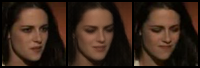

In [379]:
im_rec2 = sample_figure(im_s2, im_t2)
sample_grid(torch.cat([im_s2, im_rec2, im_t2], dim=0), 3)

In [381]:
sample_grid(torch.cat([im_s, im_rec, im_t, im_s2, im_rec2, im_t2], dim=0), 3).save('figure.png')

In [ ]:
im, conditions = preprocess_batch(im_s, ldmk_s[0])